Copyright 2023 Google LLC

Licensed under the Apache License, Version 2.0 (the "License"); you may not use
this file except in compliance with the License. You may obtain a copy of the
License at

```
 https://www.apache.org/licenses/LICENSE-2.0
```

Unless required by applicable law or agreed to in writing, software distributed
under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR
CONDITIONS OF ANY KIND, either express or implied. See the License for the
specific language governing permissions and limitations under the License.

# Simple NN with Flax.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/google-deepmind/optax/blob/master/examples/flax_example.ipynb)

This notebook trains a simple one-layer NN with Optax and Flax. For more advanced applications of those two libraries, we recommend checking out the [`cifar10_resnet`](https://colab.sandbox.google.com/github/google-deepmind/optax/blob/master/examples/cifar10_resnet.ipynb) example.

In [ ]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from flax import linen as nn

In [ ]:
# @markdown Learning rate for the optimizer:
LEARNING_RATE = 1e-2  # @param{type:"number"}
# @markdown Number of training steps:
NUM_STEPS = 100  # @param{type:"integer"}
# @markdown Number of samples in the training dataset:
NUM_SAMPLES = 20  # @param{type:"integer"}
# @markdown Shape of the input:
X_DIM = 10  # @param{type:"integer"}
# @markdown Shape of the target:
Y_DIM = 5  # @param{type:"integer"}


In this cell, we initialize a random number generator (RNG) and use it to create separate RNGs for all randomness-related things.

In [ ]:
rng = jax.random.PRNGKey(0)
params_rng, w_rng, b_rng, samples_rng, noise_rng = jax.random.split(rng, num=5)

In the next cell, we define a model and obtain its initial parameters.

In [ ]:
# Creates a one linear layer instance.
model = nn.Dense(features=Y_DIM)

# Initializes the parameters.
params = model.init(params_rng, jnp.ones((X_DIM,), dtype=jnp.float32))

In the next cell we generate our training data.

We will be approximating a function of the form `y = wx + b`, hence why we generate `w`, `b`, training samples `x` and obtain `y`, using the formula above.

In [ ]:
# Generates ground truth w and b.
w = jax.random.normal(w_rng, (X_DIM, Y_DIM))
b = jax.random.normal(b_rng, (Y_DIM,))

# Generates training samples.
x_samples = jax.random.normal(samples_rng, (NUM_SAMPLES, X_DIM))
y_samples = jnp.dot(x_samples, w) + b
# Adds noise to the target.
y_samples += 0.1 * jax.random.normal(noise_rng, (NUM_SAMPLES, Y_DIM))

Next we define a custom MSE loss function.

In [ ]:
def make_mse_func(x_batched, y_batched):
  def mse(params):
    # Defines the squared loss for a single (x, y) pair.
    def squared_error(x, y):
      pred = model.apply(params, x)
      return jnp.inner(y-pred, y-pred) / 2.0
    # Vectorises the squared error and computes mean over the loss values.
    return jnp.mean(jax.vmap(squared_error)(x_batched, y_batched), axis=0)
  return jax.jit(mse)  # `jit`s the result.

# Instantiates the sampled loss.
loss = make_mse_func(x_samples, y_samples)

# Creates a function that returns value and gradient of the loss.
loss_grad_fn = jax.value_and_grad(loss)

In the next cell, we construct a simple Adam optimiser using Optax gradient transformations passed to the `optax.chain`.

The same result can be achieved by using the `optax.adam` alias. However, here, we demonstrate how to work with gradient transformations manually so that you can build your own custom optimiser if needed.

In [ ]:
tx = optax.chain(
    # Sets the parameters of Adam. Note the learning_rate is not here.
    optax.scale_by_adam(b1=0.9, b2=0.999, eps=1e-8),
    # Puts a minus sign to *minimise* the loss.
    optax.scale(-LEARNING_RATE)
)

We then pass the initial parameters of the model to the optimiser to initialize it.

In [ ]:
opt_state = tx.init(params)

Finally, we train the model for `NUM_STEPS` steps.

In [ ]:
loss_history = []

# Minimises the loss.
for _ in range(NUM_STEPS):
  # Computes gradient of the loss.
  loss_val, grads = loss_grad_fn(params)
  loss_history.append(loss_val)
  # Updates the optimiser state, creates an update to the params.
  updates, opt_state = tx.update(grads, opt_state)
  # Updates the parameters.
  params = optax.apply_updates(params, updates)

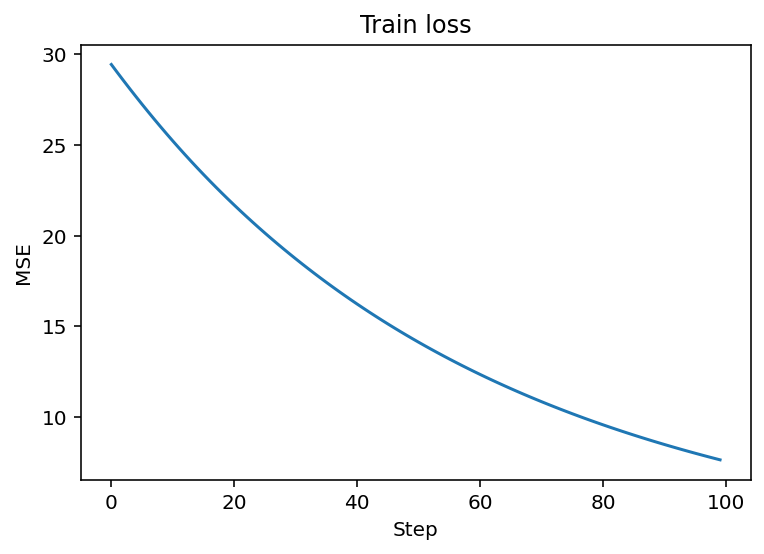

In [ ]:
plt.plot(loss_history)
plt.title('Train loss')
plt.xlabel('Step')
plt.ylabel('MSE')
plt.show()